In [6]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

import category_encoders as cat_enc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

import pickle
import datetime

In [7]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])
# integrate train, test for check & correct data
train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Check Data

In [8]:
print('train: ')
print(train.info(), '\n')
print('test: ')
print(test.info(), '\n')
print('sample_sub: ')
print(sample_sub.info())

train: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            500 non-null    int64  
 1   mpg           500 non-null    float64
 2   cylinders     500 non-null    int64  
 3   displacement  500 non-null    int64  
 4   horsepower    500 non-null    object 
 5   weight        500 non-null    int64  
 6   acceleration  500 non-null    float64
 7   model year    500 non-null    int64  
 8   origin        500 non-null    int64  
 9   car name      500 non-null    object 
dtypes: float64(2), int64(6), object(2)
memory usage: 39.2+ KB
None 

test: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            500 non-null    int64  
 1   cylinders     500 non-null    int64  
 2   displacement 

In [9]:
print('train data:')
display(train.head())
print('test data:')
display(test.head())
print('sample_sub data:')
display(sample_sub.head())

train data:


,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,23.059782,6,140,110,2815,17.977429,80,1,dodge aspen
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage
2,4,17.136353,8,302,140,2774,13.209912,79,1,mercury cougar brougham
3,7,22.664666,6,400,85,2190,15.196381,71,1,pontiac j2000 se hatchback
4,9,17.872018,8,429,220,2245,9.621400,70,1,ford galaxie 500


test data:


,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,4,98,67,2000,15.049795,81,1,peugeot 504
1,2,4,97,90,2720,15.339172,79,1,dodge aspen
2,5,4,90,75,2807,17.821599,77,1,dodge monaco brougham
3,6,4,140,110,2807,13.780354,82,2,buick century limited
4,8,4,121,85,3070,13.688921,73,2,saab 99le


sample_sub data:


,id,mpg
0,1,0.0
1,2,0.0
2,5,0.0
3,6,0.0
4,8,0.0


- check id each data frame

In [10]:
print('train id == test id:', (test['id'] == train['id']).any())
print('test id == sample_sub id:', (test['id'] == sample_sub['id']).any())

train id == test id: False
test id == sample_sub id: True


- check summary each data frame

## check categorical data(car name)

In [11]:
train_test['car name'].unique()

array(['dodge aspen', 'dodge rampage', 'mercury cougar brougham',
       'pontiac j2000 se hatchback', 'ford galaxie 500',
       'vw rabbit custom', 'amc gremlin', 'dodge monaco brougham',
       'datsun 200sx', 'renault lecar deluxe', 'pontiac lemans v6',
       'datsun 210', 'peugeot 505s turbo diesel', 'datsun 200-sx',
       'chevrolet vega', 'datsun 710', 'ford futura',
       'fiat 124 sport coupe', 'triumph tr7 coupe', 'buick century',
       'honda civic 1300', 'vw rabbit', 'chevrolet nova',
       'buick regal sport coupe (turbo)', 'ford gran torino',
       'ford pinto', 'chevrolet caprice classic', 'peugeot 504',
       'buick lesabre custom', 'chevrolet woody', 'opel 1900', 'capri ii',
       'mercury capri 2000', 'chevrolet monza 2+2', 'dodge aries se',
       'datsun 210 mpg', 'datsun 810 maxima', 'pontiac astro',
       'toyota mark ii', 'ford mustang ii 2+2', 'datsun pl510',
       'chevrolet impala', 'audi 5000s (diesel)', 'buick century limited',
       'volkswagen r

- car name is complecate, so grouping them

In [12]:
tmp = train_test['car name'].apply(lambda x:x.strip().split(' ')[0])
brands = tmp.unique()

for brand in brands:
    print('brand: ', brand)
    print(train_test.loc[train_test['car name'].str.startswith(brand), 'car name'].unique(), '\n')

brand:  dodge
['dodge aspen' 'dodge rampage' 'dodge monaco brougham' 'dodge aries se'
 'dodge colt' 'dodge magnum xe' 'dodge coronet custom' 'dodge omni'] 

brand:  mercury
['mercury cougar brougham' 'mercury capri 2000' 'mercury zephyr 6'] 

brand:  pontiac
['pontiac j2000 se hatchback' 'pontiac lemans v6' 'pontiac astro'] 

brand:  ford
['ford galaxie 500' 'ford futura' 'ford gran torino' 'ford pinto'
 'ford mustang ii 2+2' 'ford ltd' 'ford granada l' 'ford fairmont (man)'
 'ford gran torino (sw)' 'ford escort 4w' 'ford f108' 'ford fairmont'] 

brand:  vw
['vw rabbit custom' 'vw rabbit'] 

brand:  amc
['amc gremlin' 'amc pacer d/l' 'amc ambassador dpl' 'amc hornet'
 'amc matador' 'amc spirit dl' 'amc concord d/l'] 

brand:  datsun
['datsun 200sx' 'datsun 210' 'datsun 200-sx' 'datsun 710' 'datsun 210 mpg'
 'datsun 810 maxima' 'datsun pl510' 'datsun 510 (sw)' 'datsun 1200'
 'datsun f-10 hatchback'] 

brand:  renault
['renault lecar deluxe'] 

brand:  peugeot
['peugeot 505s turbo diesel

## check unique horsepower  
horsepower should be numeric, but is object type

In [13]:
train_test['horsepower'].unique()

array(['110', '150', '140', '85', '220', '165', '60', '?', '90', '67',
       '97', '72', '122', '139', '88', '100', '105', '54', '71', '78',
       '75', '148', '130', '95', '70', '112', '69', '132', '120', '108',
       '74', '96', '61', '193', '58', '82', '80', '145', '64', '135',
       '190', '113', '62', '92', '170', '153', '63', '86'], dtype=object)

# Correct data

correct car name speling inconsistency

In [14]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

convert horsepower object to float

In [15]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

check data which horsepower is null(replace from ?)

In [16]:
train_test[train_test['horsepower'].isnull()]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,24,44.763897,4,85,NaN,1755,17.503013,80,2,renault lecar deluxe
48,96,23.008702,4,140,NaN,1760,19.472427,76,1,volkswagen rabbit
224,454,28.146944,4,140,NaN,1760,19.420540,76,1,volkswagen rabbit
286,574,44.021790,4,85,NaN,1955,20.795175,80,2,pontiac astro
320,645,44.410105,4,85,NaN,1955,21.057837,80,2,pontiac astro
407,815,28.048825,4,140,NaN,1760,19.139558,71,1,volkswagen rabbit
415,831,28.079580,4,140,NaN,1760,17.268393,82,1,volkswagen rabbit
455,901,27.536418,4,140,NaN,1760,19.243466,76,1,volkswagen rabbit
487,970,27.725048,4,140,NaN,1760,19.532434,76,1,volkswagen rabbit
598,206,NaN,4,85,NaN,4274,20.917523,78,2,ford pinto


# Regression horsepower
Using Stacking with 2-layers & 3-models(below)  
Layer1: LightGBM, SVR(Support Vector Regression)  
Layer2: Ridge Regression

## prepare data for regression horsepower

In [17]:
cat_cols = ['car name']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])
    
train_test_hp = train_test.drop(['id'], axis=1)
test_x_hp = train_test_hp[train_test_hp['horsepower'].isnull()].drop(['horsepower'], axis=1)
train_hp = train_test_hp.dropna(subset=['horsepower'], axis=0)
train_y_hp = train_hp['horsepower'].copy()
train_x_hp = train_hp.drop(['horsepower'], axis=1)

print('Data for regression horsepower\ntrain_x:')
display(train_x_hp)
print('train_y:')
display(train_y_hp)
print('test_x:')
display(test_x_hp)

Data for regression horsepower
train_x:


,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
0,23.059782,6,140,2815,17.977429,80,1,33
1,17.674521,8,350,4456,13.514535,72,1,39
2,17.136353,8,302,2774,13.209912,79,1,59
3,22.664666,6,400,2190,15.196381,71,1,72
4,17.872018,8,429,2245,9.621400,70,1,47
...,...,...,...,...,...,...,...,...
995,NaN,4,225,3870,15.376311,76,1,21
996,NaN,4,140,2720,13.616843,82,1,9
997,NaN,8,318,2774,13.272636,75,1,51
998,NaN,4,90,2807,17.792560,77,1,37


train_y:


0      110.0
1      150.0
2      140.0
3       85.0
4      220.0
       ...  
995    105.0
996    112.0
997    110.0
998     75.0
999     69.0
Name: horsepower, Length: 985, dtype: float64

test_x:


,mpg,cylinders,displacement,weight,acceleration,model year,origin,car name
10,44.763897,4,85,1755,17.503013,80,2,74
48,23.008702,4,140,1760,19.472427,76,1,84
224,28.146944,4,140,1760,19.420540,76,1,84
286,44.021790,4,85,1955,20.795175,80,2,71
320,44.410105,4,85,1955,21.057837,80,2,71
407,28.048825,4,140,1760,19.139558,71,1,84
415,28.079580,4,140,1760,17.268393,82,1,84
455,27.536418,4,140,1760,19.243466,76,1,84
487,27.725048,4,140,1760,19.532434,76,1,84
598,NaN,4,85,4274,20.917523,78,2,53


In [18]:
cols = ['displacement', 'acceleration', 'weight', 'model year']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train_test_svr = train_test.copy()
train_test_svr[cols] = scaler.fit_transform(train_test_svr[cols])

cat_col1 = ['cylinders', 'origin']
cat_col2 = ['car name']
train_test_svr = pd.get_dummies(train_test_svr, columns=cat_col1, sparse=False)
train_test_svr = cat_enc.binary.BinaryEncoder(cols=cat_cols).fit_transform(train_test_svr)

train_test_svr = train_test_svr.drop(['id', 'mpg'], axis=1)
test_x_hp_svr = train_test_svr[train_test_svr['horsepower'].isnull()].drop(['horsepower'], axis=1).copy()
train_x_hp_svr = train_test_svr.dropna(subset=['horsepower'], axis=0).drop(['horsepower'], axis=1).copy()

display(train_x_hp_svr)
display(test_x_hp_svr)

,displacement,weight,acceleration,model year,car name_0,car name_1,car name_2,car name_3,car name_4,car name_5,car name_6,car name_7,cylinders_4,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,-0.483685,0.120895,1.195071,0.950375,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1,1.521800,2.456808,-0.797646,-1.117905,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,1.063404,0.062533,-0.933663,0.691840,0,0,0,0,0,0,1,1,0,0,1,1,0,0
3,1.999297,-0.768773,-0.046689,-1.376440,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,2.276245,-0.690482,-2.535961,-1.634975,0,0,0,0,0,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.328059,1.622655,0.033651,-0.083765,0,0,0,1,0,1,1,0,1,0,0,1,0,0
996,-0.483685,-0.014334,-0.751965,1.467445,0,0,1,0,1,0,1,0,1,0,0,1,0,0
997,1.216202,0.062533,-0.905656,-0.342300,0,0,1,1,1,0,1,0,0,0,1,1,0,0
998,-0.961181,0.109507,1.112525,0.174770,0,0,0,0,1,0,0,0,1,0,0,1,0,0


,displacement,weight,acceleration,model year,car name_0,car name_1,car name_2,car name_3,car name_4,car name_5,car name_6,car name_7,cylinders_4,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
10,-1.008931,-1.387982,0.983240,0.950375,0,0,0,0,1,0,1,0,1,0,0,0,1,0
48,-0.483685,-1.380865,1.862599,-0.083765,0,0,0,1,0,1,0,1,1,0,0,1,0,0
224,-0.483685,-1.380865,1.839431,-0.083765,0,0,0,1,0,1,0,1,1,0,0,1,0,0
286,-1.008931,-1.103288,2.453216,0.950375,0,0,1,0,0,1,0,0,1,0,0,0,1,0
320,-1.008931,-1.103288,2.570497,0.950375,0,0,1,0,0,1,0,0,1,0,0,0,1,0
407,-0.483685,-1.380865,1.713970,-1.376440,0,0,0,1,0,1,0,1,1,0,0,1,0,0
415,-0.483685,-1.380865,0.878481,1.467445,0,0,0,1,0,1,0,1,1,0,0,1,0,0
455,-0.483685,-1.380865,1.760366,-0.083765,0,0,0,1,0,1,0,1,1,0,0,1,0,0
487,-0.483685,-1.380865,1.889393,-0.083765,0,0,0,1,0,1,0,1,1,0,0,1,0,0
598,-1.008931,2.197736,2.507846,0.433305,0,0,0,1,1,0,0,1,1,0,0,0,1,0


## Define Regression Models

In [19]:
# LightGBM
class Model_Lgbm:
    def __init__(self, params):
        if 'max_depth' in params:
            params['max_depth'] = int(params['max_depth'])
        if 'num_leaves' in params:
            params['num_leaves'] = int(params['num_leaves'])
        if 'min_data_in_leaf' in params:
            params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        if 'n_estimators' in params:
            params['n_estimators'] = int(params['n_estimators'])
        if 'subsample_for_bin' in params:
            params['subsample_for_bin'] = int(params['subsample_for_bin'])
        if 'min_child_samples' in params:
            params['min_child_samples'] = int(params['min_child_samples'])
        if 'subsample_freq' in params:
            params['subsample_freq'] = int(params['subsample_freq'])
        if 'n_jobs' in params:
            params['n_jobs'] = int(params['n_jobs'])

        self.params = params
        self.model = lgb.LGBMRegressor(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        return self.model.predict(x)
    
# Support Vector Machine
class Model_SVR:
    def __init__(self, params):
        self.params = params
        self.model = SVR(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
        #self.model = model
    
    def predict(self, x):
        return self.model.predict(x)
    
# Random Forest
class Model_RF:    
    def __init__(self, params):
        if 'n_estimators' in params:
            params['n_estimators'] = int(params['n_estimators'])
        if 'max_depth' in params:
            params['max_depth'] = int(params['max_depth'])
        if 'min_samples_split' in params:
            params['min_samples_split'] = int(params['min_samples_split'])
        if 'min_samples_leaf' in params:
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
        
        self.params = params
        self.model = RandomForestRegressor(**self.params)
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
    
    def predict(self, x):
        return self.model.predict(x)

# Ridge Regression
class Model_Ridge:
    def __init__(self, params):
        self.params = params
        self.model = Ridge(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict(x)
        return self.model.predict(x)

## Define Functions

In [20]:
# Evaluation Function
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

# Objective Function for model's hyperparameter optimization
def objective(x, y, args):  
    if args['model_type'] == 'lgb':
        del args['model_type']
        reg = Model_Lgbm(args)
    elif args['model_type'] == 'svr':
        del args['model_type']
        reg = Model_SVR(args)
    elif args['model_type'] == 'nn':
        del args['model_type']
        reg = Model_NN(args)
    elif args['model_type'] == 'rid':
        del args['model_type']
        reg = Model_Ridge(args)
    elif args['model_type'] == 'rf':
        del args['model_type']
        reg = Model_RF(args)
    elif args['model_type'] == 'et':
        del args['model_type']
        reg = Model_ET(args)
    else:
        del args['model_type']
        reg = None

    scores = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for tr_idx, va_idx in kf.split(x, y):
        tr_x = x.iloc[tr_idx]
        tr_y = y.iloc[tr_idx]
        va_x = x.iloc[va_idx]
        va_y = y.iloc[va_idx]
        
        reg.fit(tr_x, tr_y, va_x, va_y)        
        va_pred = reg.predict(va_x)
        score = RMSE(va_y, va_pred)
        scores.append(score)
        
    return {
        'loss': np.mean(scores),
        'status':STATUS_OK,
        'params':args
    }

# show optimization results
def show_trials(trials):
    result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x:x['loss'])]
    params_df = pd.concat(
        [pd.Series([i[0] for i in result], name='loss'),
        pd.DataFrame([i[1] for i in result])],
        axis=1
    )
    params_df.iloc[:100].plot.line(
        figsize=(20, 60), marker='o', subplots=True, legend=True, grid=True
    )
    plt.show()

# Stacking cross-validation
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        va_idxes.append(va_idx)
    
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis=0)
    
    return pred_train, preds_test

## Parameter Tuning using Hyperopt

### Layer1: LightGBM

100%|██████████████████████████████████████████████| 500/500 [01:28<00:00,  5.65trial/s, best loss: 22.589089698957466]
best_params:
{'alpha': 4.176715850473232e-06,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.75,
 'gamma': 0.7000000000000001,
 'lambda': 0.027248065547792827,
 'max_depth': 6.0,
 'min_child_weight': 9.0,
 'num_leaves': 20.0}


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


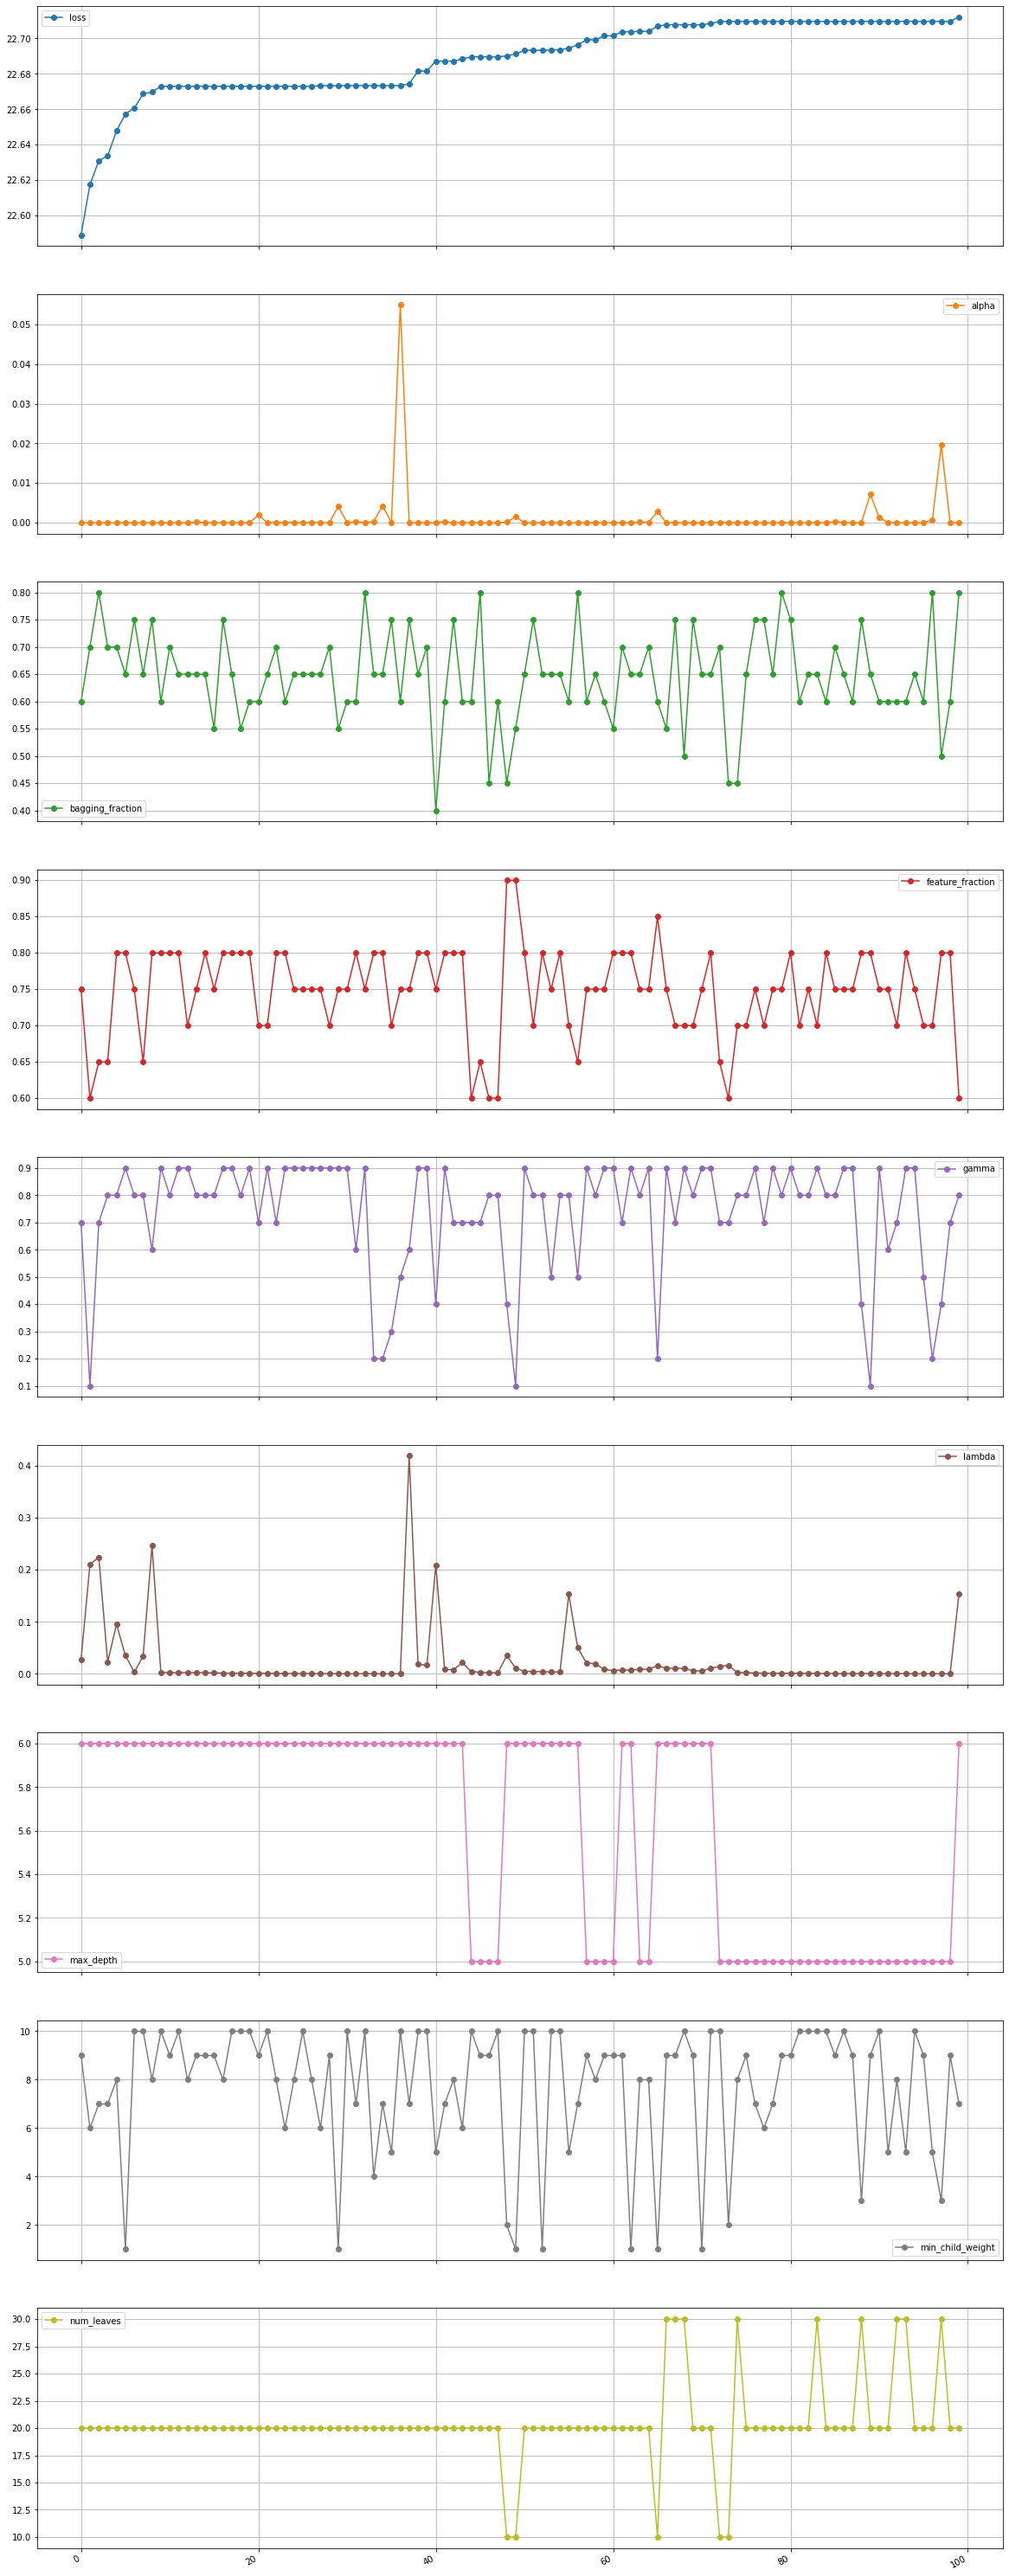

In [21]:
params_lgb = {
    'model_type': 'lgb',
    'alpha' : hp.loguniform(label='alpha', low=np.log(1e-8), high=np.log(0.1)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.4, high=0.80, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.4, high=0.9, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.9, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(0.6)),
    'max_depth': hp.quniform(label='max_depth', low=5, high=13, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=10, q=1),
    'num_leaves': hp.quniform(label='num_leaves', low=5, high=30, q=10)
}

f_lgb = partial(objective, train_x_hp, train_y_hp)
trials_lgb = Trials()

best_lgb = fmin(
    fn=f_lgb,
    space=params_lgb,
    algo=tpe.suggest,
    trials=trials_lgb,
    max_evals=500
)

print('best_params:')
pprint.pprint(best_lgb)
show_trials(trials_lgb)

### Layer1: SVR(Support Vector Regression)

100%|██████████████████████████████████████████████| 500/500 [01:16<00:00,  6.50trial/s, best loss: 24.410040593468477]
best_params:
{'C': 12.322017894604969,
 'epsilon': 1.3776584345224256,
 'gamma': 0.2991904920743628}


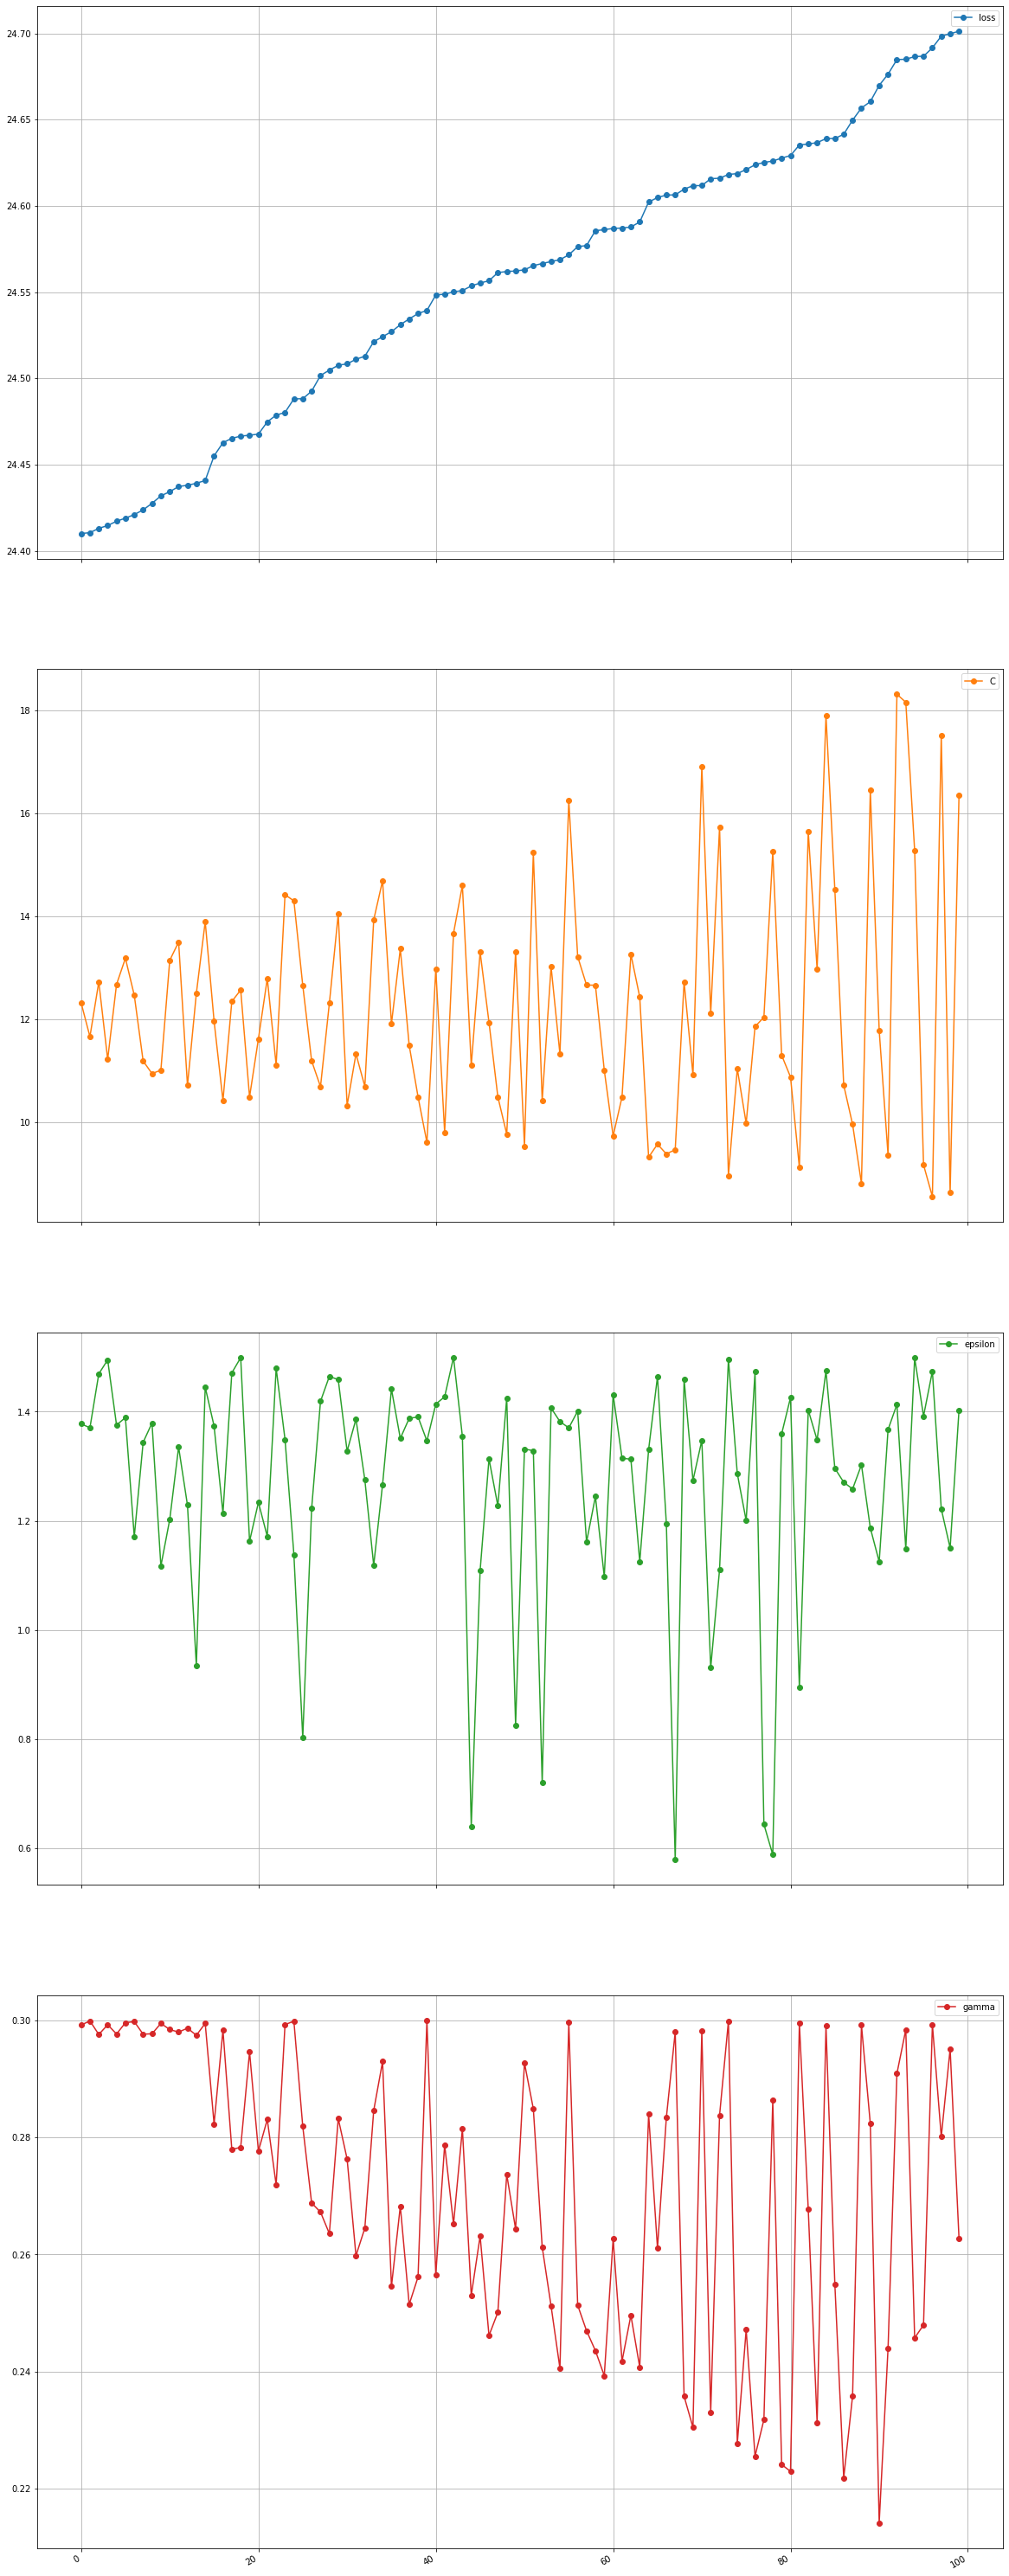

In [22]:
params_svr = {
    'model_type': 'svr',
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(1), high=np.log(30)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(0.5), high=np.log(1.5)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(0.01), high=np.log(0.3)
    )
}

f_svr = partial(objective, train_x_hp_svr, train_y_hp)
trials_svr = Trials()

best_svr = fmin(
    fn=f_svr,
    space=params_svr,
    algo=tpe.suggest,
    trials=trials_svr,
    max_evals=500
)

print('best_params:')
pprint.pprint(best_svr)
show_trials(trials_svr)

## Prepare data for Layer2

In [23]:
model_1a = Model_Lgbm(params=sorted(trials_lgb.results, key=lambda x: x['loss'])[0]['params'])
model_1b = Model_SVR(params=sorted(trials_svr.results, key=lambda x: x['loss'])[0]['params'])

pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x_hp, train_y_hp, test_x_hp)
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_hp_svr, train_y_hp, test_x_hp_svr)

score_1a = RMSE(train_y_hp, pred_train_1a)
score_1b = RMSE(train_y_hp, pred_train_1b)
print(f'model_1a(lgb) score: {score_1a:.4f}')
print(f'model_1b(svr) score: {score_1b:.4f}')

model_1a(lgb) score: 23.0762
model_1b(svr) score: 24.5642


In [24]:
# Create DataFrame from predict value as features
train_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_train_1a, 
    'pred_1b(svr)': pred_train_1b,
})
test_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_test_1a,
    'pred_1b(svr)': pred_test_1b,
})
display(train_x_2)
display(test_x_2)

,pred_1a(lgb),pred_1b(svr)
0,106.895426,109.659140
1,155.918827,148.604383
2,135.911395,138.761100
3,87.040788,98.326088
4,182.525363,153.627928
...,...,...
980,99.374510,94.573704
981,119.032274,110.497479
982,135.658257,140.510572
983,95.485801,107.289831


,pred_1a(lgb),pred_1b(svr)
0,84.049398,93.749639
1,79.755800,77.854051
2,81.266420,77.816872
3,71.902046,101.281357
4,72.175790,101.644973
5,85.531501,73.709053
6,106.667206,81.627275
7,78.936441,77.720161
8,82.755555,77.902202
9,84.996689,92.059761


## Layer2: Ridge

100%|█████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.05trial/s, best loss: 22.99400671439971]
best_params:
{'alpha': 4.0}


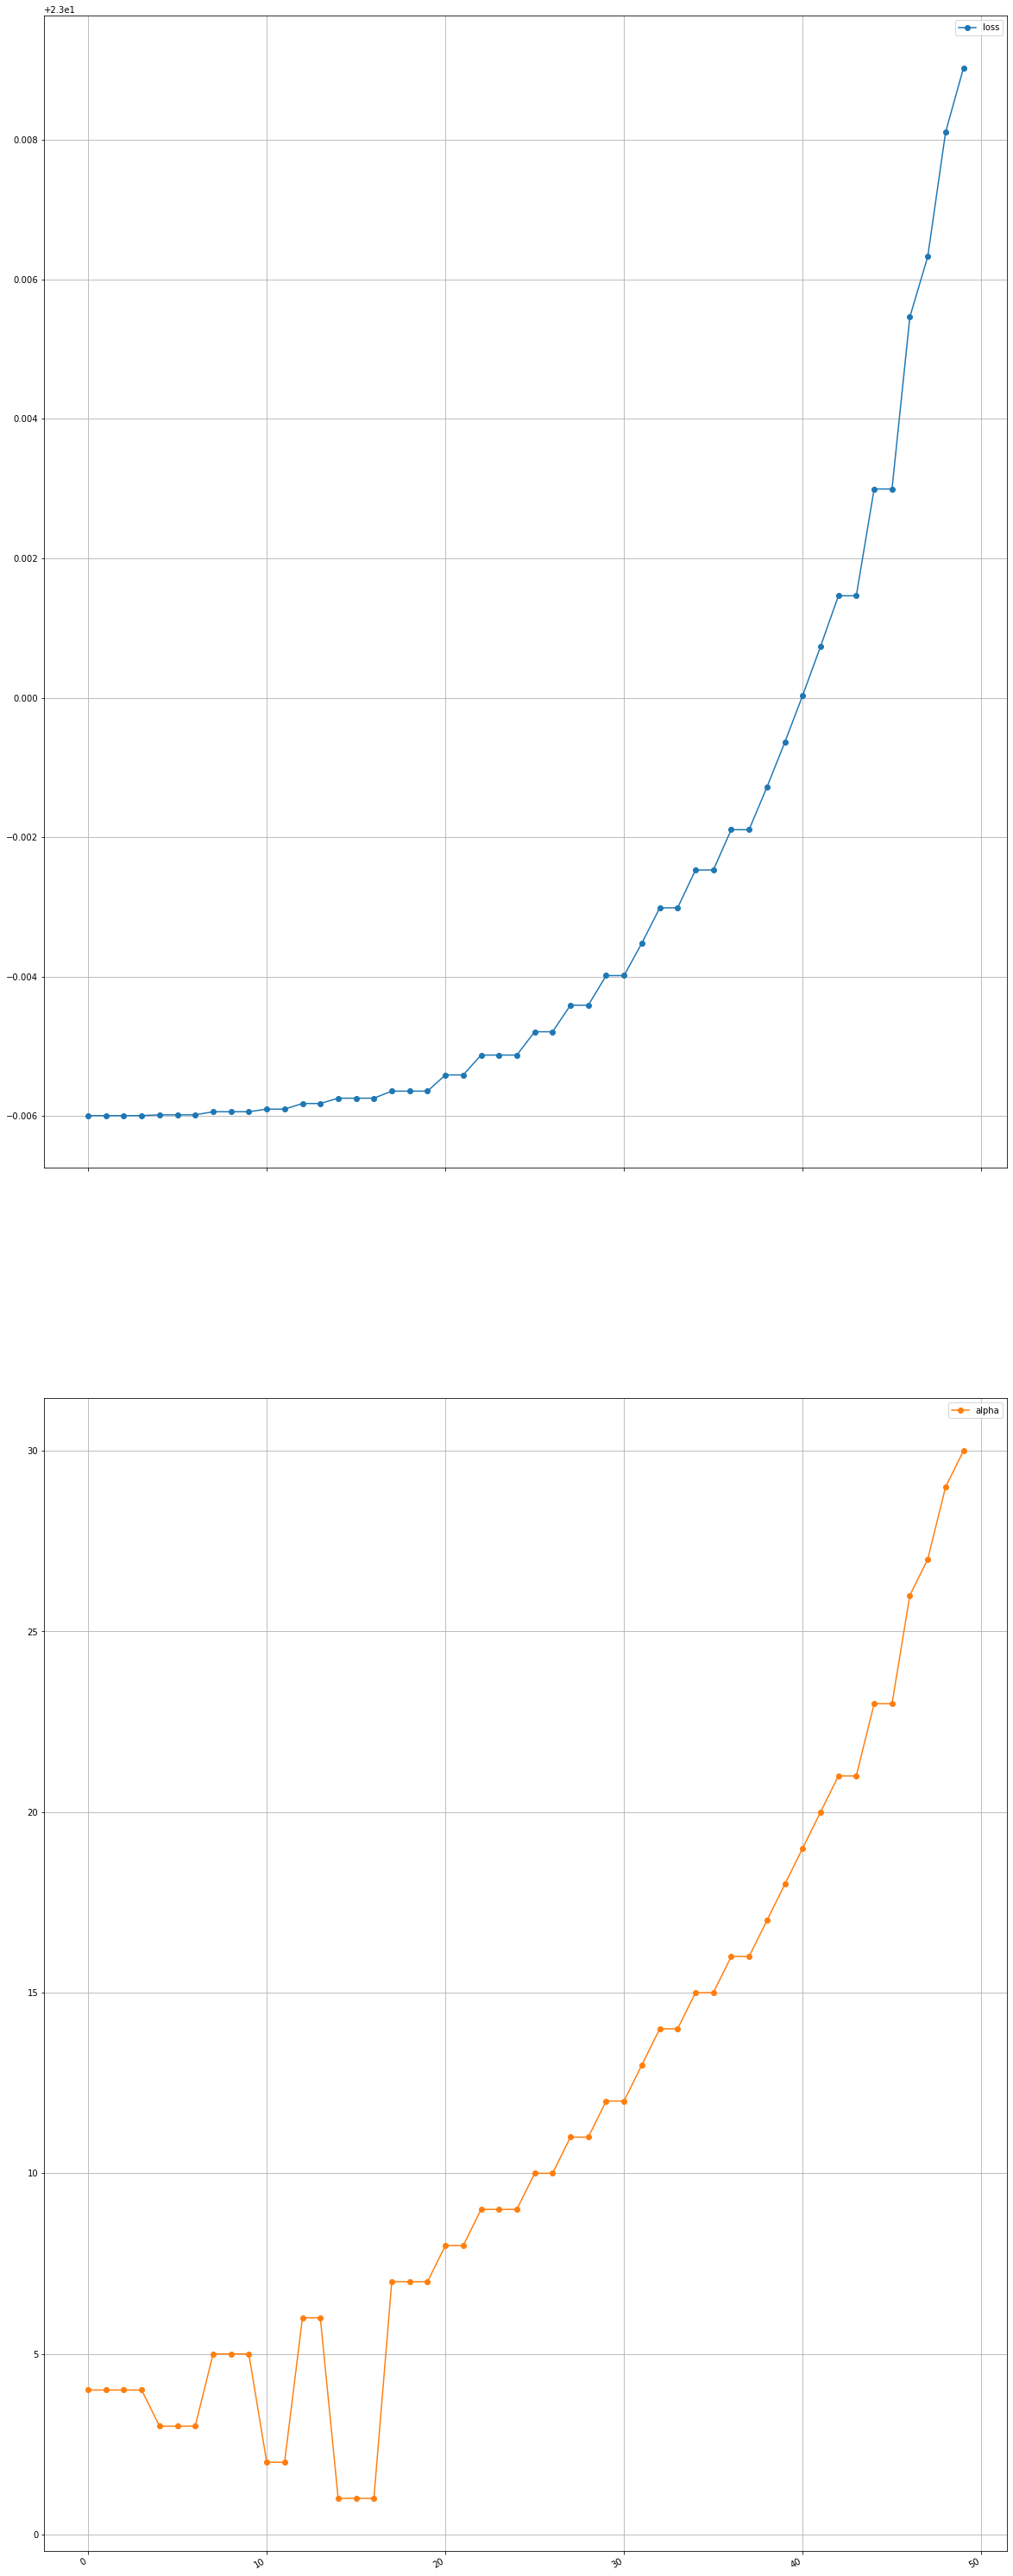

In [25]:
params_rid ={
    'model_type': 'rid',
    'alpha': hp.quniform(label='alpha', low=1, high=30, q=1),
}
max_evals = 50
trials_rid = Trials()
f_rid = partial(objective, train_x_2, train_y_hp)

best_rid = fmin(
    fn=f_rid, 
    space=params_rid, 
    algo=tpe.suggest, 
    trials=trials_rid,
    max_evals=max_evals
)

print('best_params:')
pprint.pprint(best_rid)
show_trials(trials_rid)

In [27]:
model_2 = Model_Ridge(params=sorted(trials_rid.results, key=lambda x: x['loss'])[0]['params'])
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y_hp, test_x_2)
score_2 = RMSE(train_y_hp, pred_train_2)
print(f'train score: {score_2:.4f}')
print('predict result:')
pprint.pprint(pred_test_2)

train score: 23.1032
predict result:
array([ 86.99898387,  79.86966868,  81.00345444,  79.6477828 ,
        79.94366295,  83.22726765, 101.15080431,  79.21709108,
        82.15089656,  87.30306714,  90.78294087,  85.18554713,
        95.2626203 ,  85.16946652,  73.58101374])


### Substitute prediction result

In [28]:
train_test.loc[train_test['horsepower'].isnull(), 'horsepower'] = pred_test_2

# Regression mpg

## prepare data

In [36]:
# create SVR data
train_test_svr = train_test.copy()
## Standard Scale
cols = ['displacement', 'acceleration', 'weight', 'model year']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train_test_svr[cols] = scaler.fit_transform(train_test_svr[cols])
## Encoding
cat_col1 = ['cylinders', 'origin']
cat_cols2 = ['car name']
train_test_svr = pd.get_dummies(train_test_svr, columns=cat_col1)
train_test_svr = cat_enc.binary.BinaryEncoder(cols=cat_col2).fit_transform(train_test_svr)

# Tree based feature
train_test_tree = train_test.copy()
##Encoding
train_test_tree['car name'] = LabelEncoder().fit_transform(train_test_tree['car name'])

In [37]:
train_y = train['mpg']

test_x_svr = train_test_svr[train_test_svr['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x_svr = train_test_svr.dropna(subset=['mpg'], axis=0).drop(['id', 'mpg'], axis=1).copy()

test_x_tree = train_test_tree[train_test_tree['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x_tree = train_test_tree.dropna(subset=['mpg'], axis=0).copy()
train_x_tree.drop(['id', 'mpg'], axis=1, inplace=True)

## Parameter Tuning using Hyperopt

### Layer1: LightGBM

100%|██████████████████████████████████████████████| 500/500 [01:44<00:00,  4.80trial/s, best loss: 2.7767873842194795]
best_params:
{'alpha': 0.00012662241173790365,
 'bagging_fraction': 0.5,
 'feature_fraction': 0.35000000000000003,
 'gamma': 0.4,
 'lambda': 0.012148985958653128,
 'max_depth': 8.0,
 'min_child_weight': 3.0,
 'min_data_in_leaf': 3.0,
 'num_leaves': 20.0}


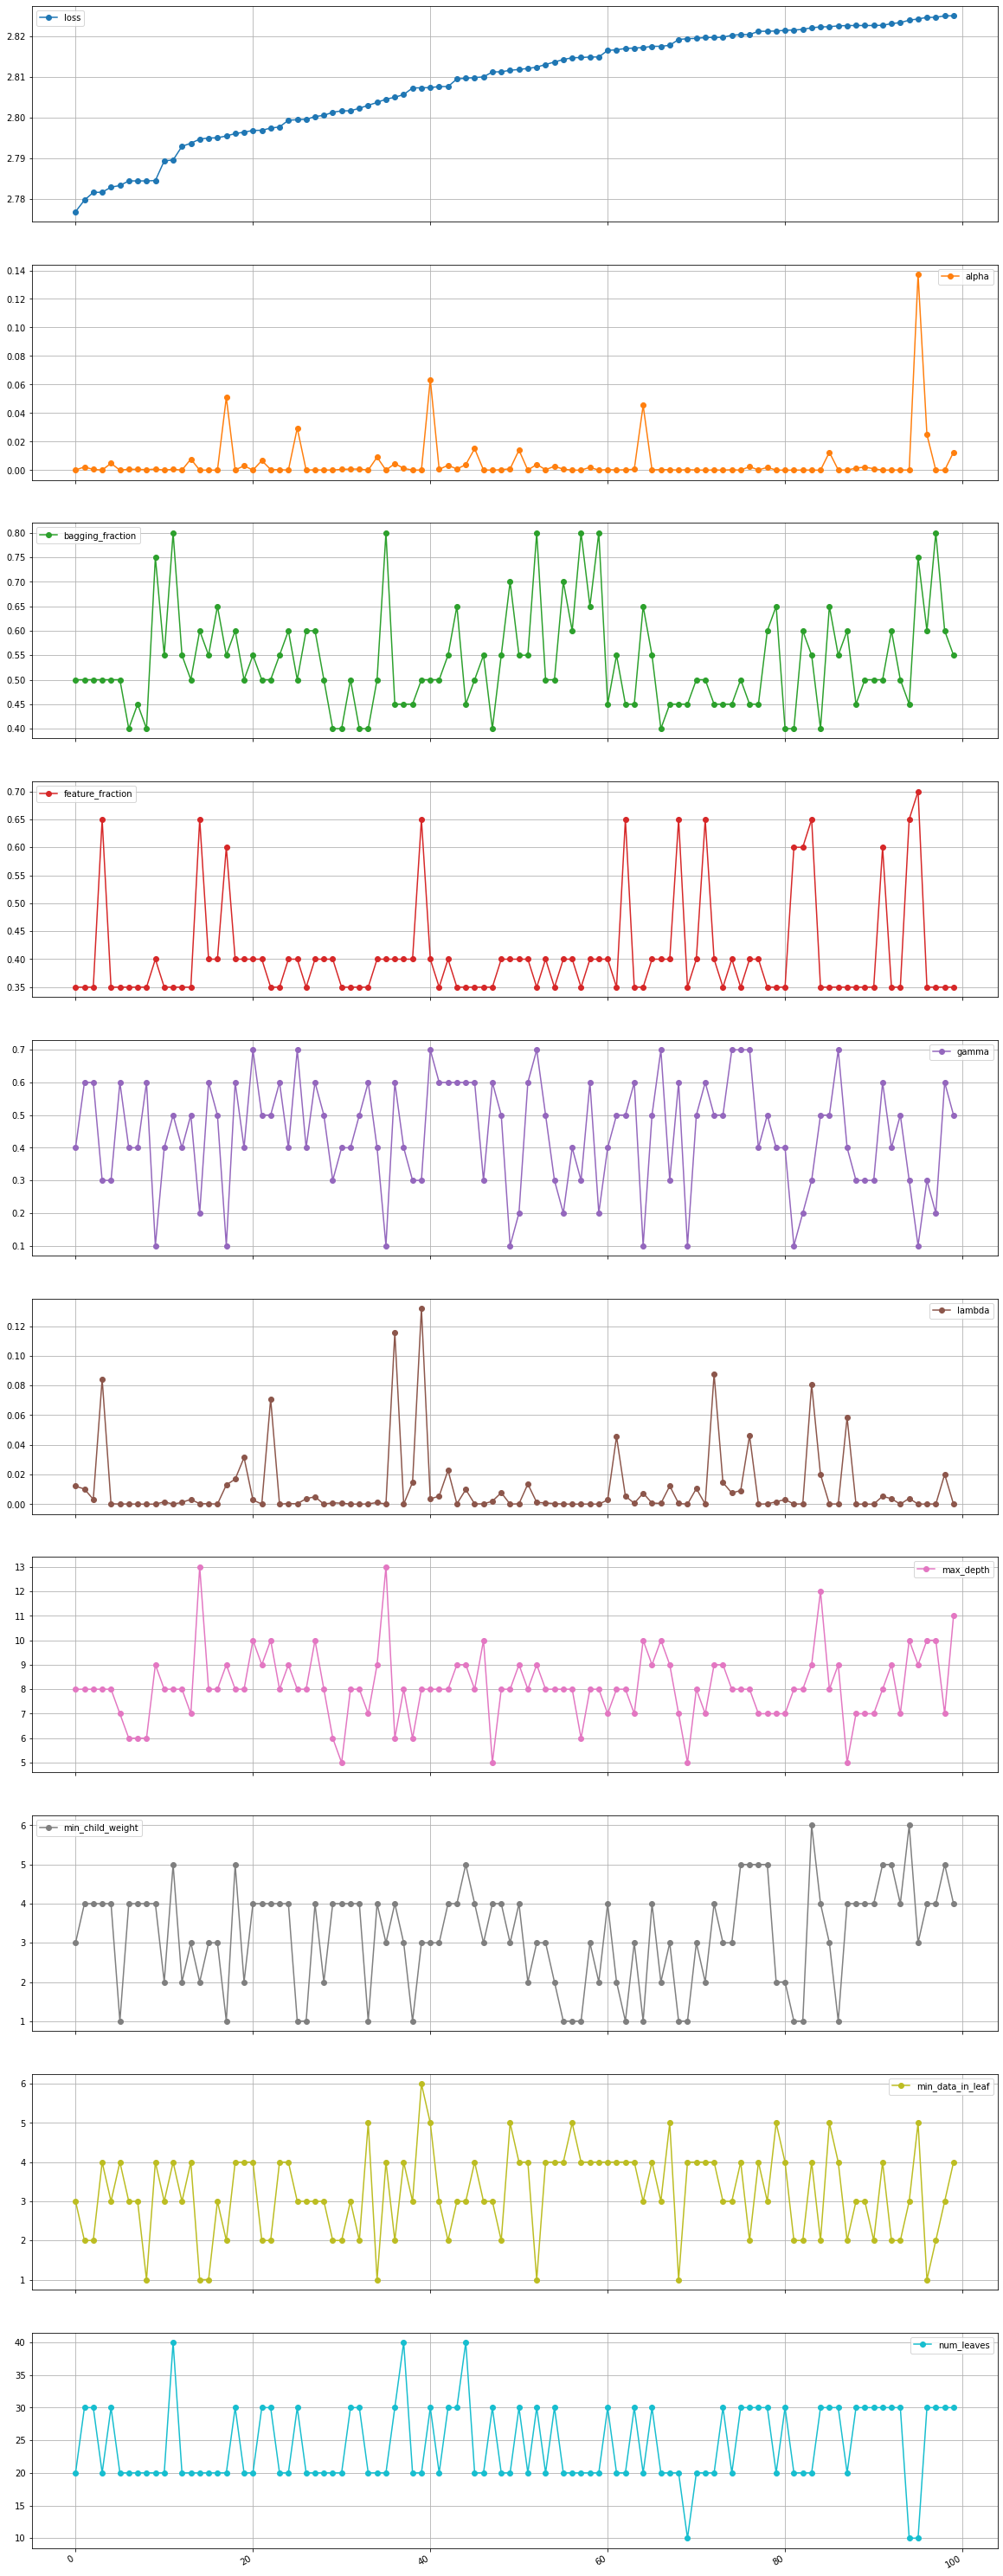

In [39]:
params_lgb = {
    'model_type': 'lgb',
    'alpha' : hp.loguniform(label='alpha', low=np.log(1e-6), high=np.log(0.2)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.4, high=0.80, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.3, high=0.7, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.7, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(0.3)),
    'max_depth': hp.quniform(label='max_depth', low=3, high=13, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=10, q=1),
    'min_data_in_leaf': hp.quniform(label='min_data_in_leaf', low=1, high=10, q=1),
    'num_leaves': hp.quniform(label='num_leaves', low=10, high=40, q=10)
}

f_lgb = partial(objective, train_x_tree, train_y)
trials_lgb = Trials()

best_lgb = fmin(
    fn=f_lgb,
    space=params_lgb,
    algo=tpe.suggest,
    trials=trials_lgb,
    max_evals=500
)

print('best_params:')
pprint.pprint(best_lgb)
show_trials(trials_lgb)

## Layer1: SVR

100%|██████████████████████████████████████████████| 500/500 [00:41<00:00, 12.16trial/s, best loss: 3.6294650731412035]
best_params:
{'C': 17.70784396152581,
 'epsilon': 0.3001778855193932,
 'gamma': 0.05690656711952305}


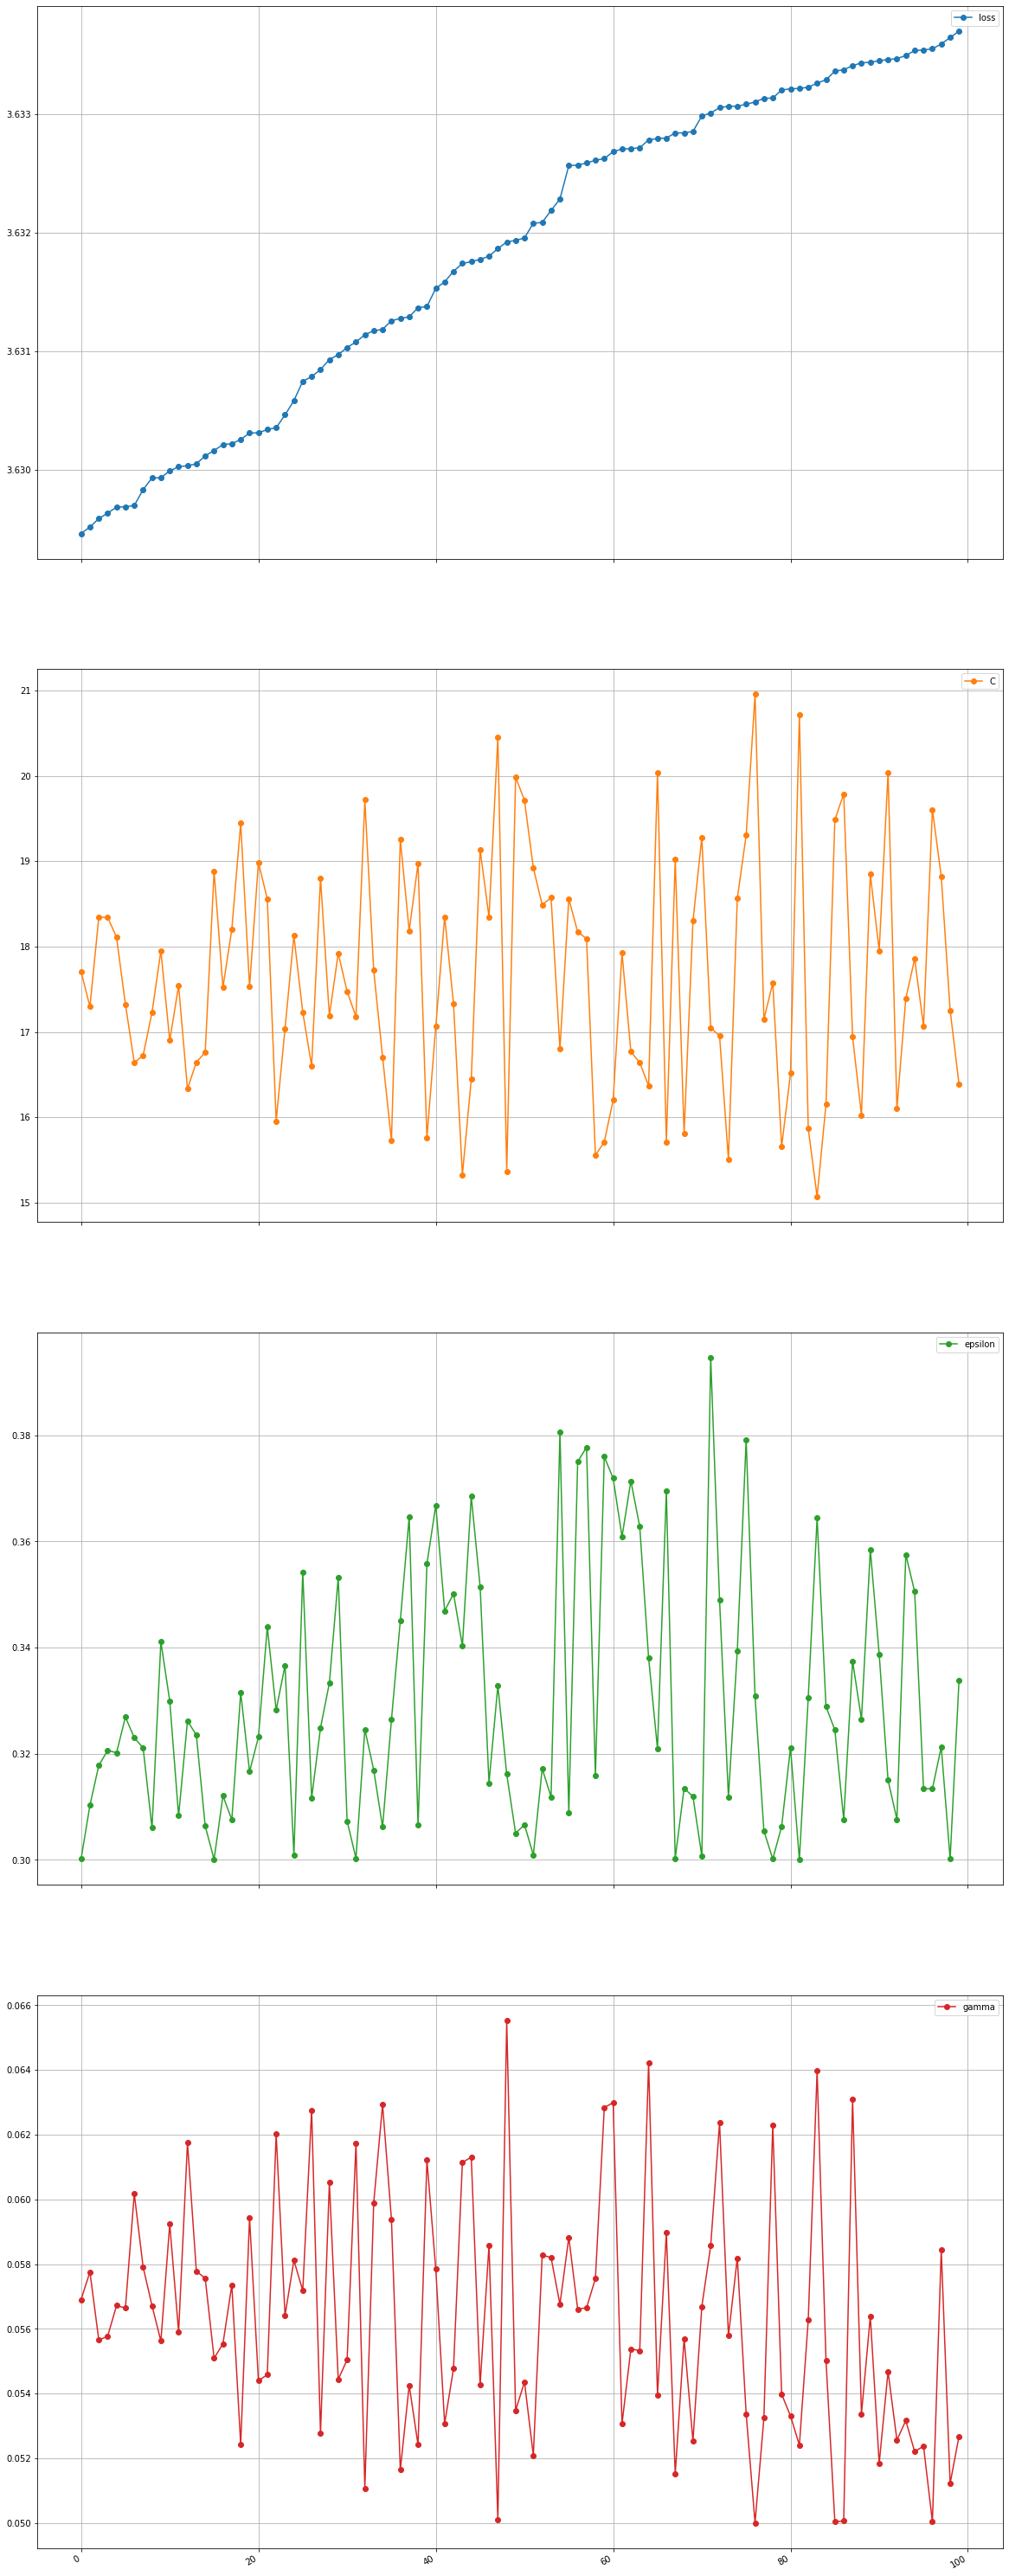

In [40]:
params_svr = {
    'model_type': 'svr',
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(10), high=np.log(25)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(0.3), high=np.log(1.0)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(0.05), high=np.log(0.2)
    )
}

f_svr = partial(objective, train_x_svr, train_y)
trials_svr = Trials()

best_svr = fmin(
    fn=f_svr,
    space=params_svr,
    algo=tpe.suggest,
    trials=trials_svr,
    max_evals=500
)

print('best_params:')
pprint.pprint(best_svr)
show_trials(trials_svr)

## Layer1: Random Forest

100%|███████████████████████████████████████████████| 500/500 [04:15<00:00,  1.96trial/s, best loss: 2.967454821008519]
best_params:
{'bootstrap': 0,
 'max_depth': 12.0,
 'min_samples_split': 3.0,
 'n_estimators': 80.0}


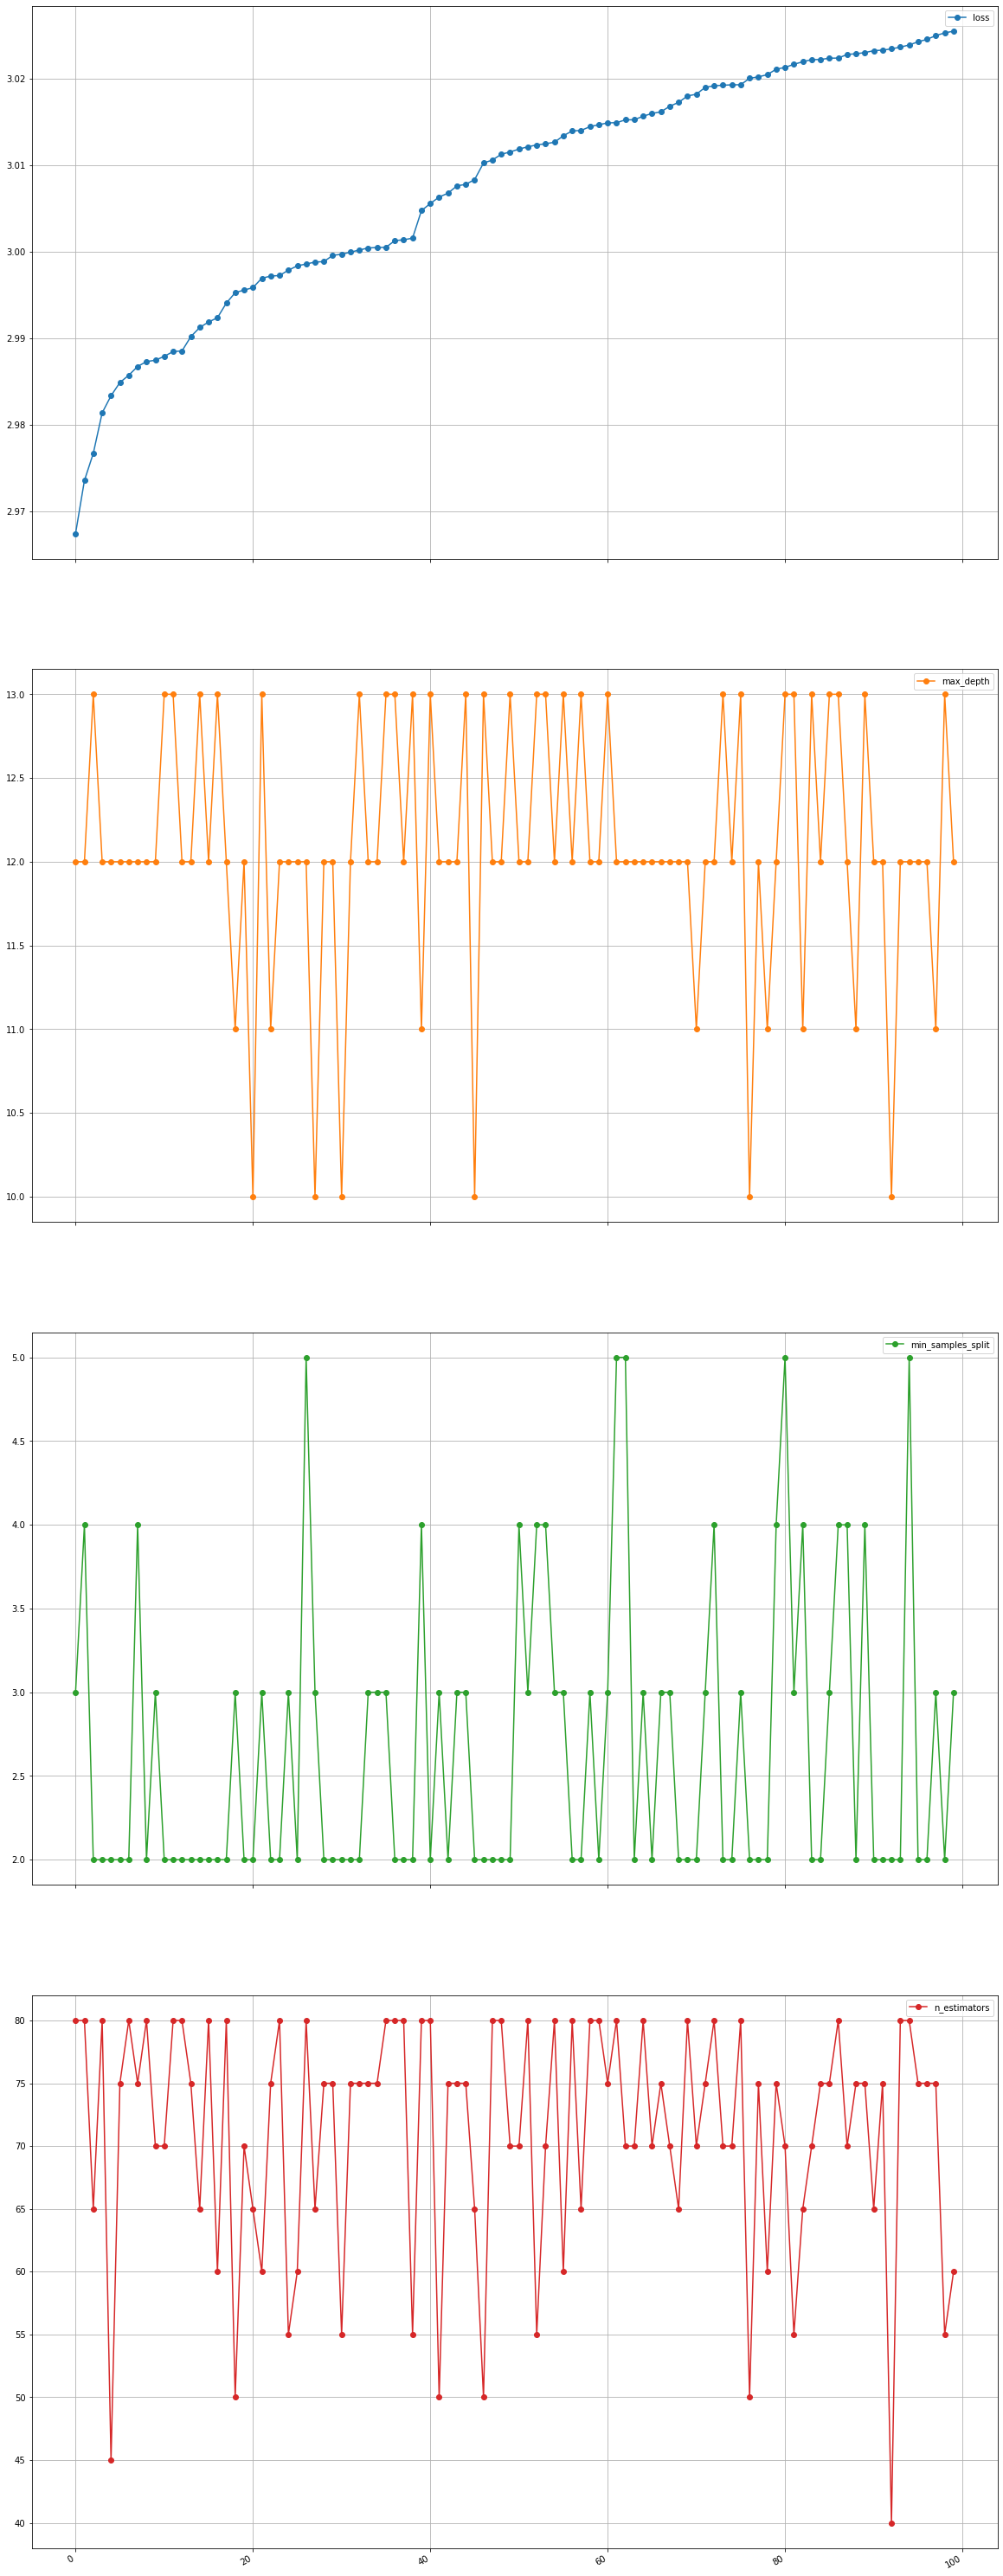

In [41]:
params_rf = {
    'model_type': 'rf',
    'max_depth': hp.quniform(label='max_depth', low=10, high=13, q=1),
    'min_samples_split': hp.quniform(label='min_samples_split', low=2, high=5, q=1),
    #'min_samples_leaf': hp.quniform(label='min_samples_leaf', low=1, high=5, q=1),
    'n_estimators': hp.quniform(label='n_estimators', low=40, high=80, q=5),
    'bootstrap': hp.choice(label='bootstrap', options=[True, False])
}

max_evals = 500
trials_rf = Trials()
f_rf = partial(objective, train_x_tree, train_y)

best_rf = fmin(
    fn=f_rf, 
    space=params_rf, 
    algo=tpe.suggest, 
    trials=trials_rf,
    max_evals=max_evals
)

print('best_params:')
pprint.pprint(best_rf)
show_trials(trials_rf)

## Prepare data for Layer2

In [42]:
model_1a = Model_Lgbm(params=sorted(trials_lgb.results, key=lambda x: x['loss'])[0]['params'])
model_1b = Model_SVR(params=sorted(trials_svr.results, key=lambda x: x['loss'])[0]['params'])
model_1c = Model_RF(params=sorted(trials_rf.results, key=lambda x: x['loss'])[0]['params'])

pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x_tree, train_y, test_x_tree)
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_svr, train_y, test_x_svr)
pred_train_1c, pred_test_1c = predict_cv(model_1c, train_x_tree, train_y, test_x_tree)

score_1a = RMSE(train_y, pred_train_1a)
score_1b = RMSE(train_y, pred_train_1b)
score_1c = RMSE(train_y, pred_train_1c)
print(f'model_1a(lgb) score: {score_1a:.4f}')
print(f'model_1b(svr) score: {score_1b:.4f}')
print(f'model_1c(rf) score: {score_1c:.4f}')

model_1a(lgb) score: 2.8639
model_1b(svr) score: 3.6624
model_1c(rf) score: 2.9903


In [43]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_train_1a, 
    'pred_1b(svr)': pred_train_1b, 
    'pred_1c(rf)': pred_train_1c,
})
test_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_test_1a,
    'pred_1b(svr)': pred_test_1b,
    'pred_1c(rf)': pred_test_1c,
})
display(train_x_2.head())
display(test_x_2.head())

,pred_1a(lgb),pred_1b(svr),pred_1c(rf)
0,23.139985,23.252063,23.299830
1,17.801283,17.226191,16.770679
2,17.762588,17.714122,17.821082
3,22.411556,22.922410,22.455096
4,17.470547,17.506100,17.508439


,pred_1a(lgb),pred_1b(svr),pred_1c(rf)
0,36.004178,36.050073,35.802223
1,27.621450,30.676801,29.164865
2,28.219376,27.343683,27.763882
3,30.763643,32.051454,31.748034
4,24.510438,28.170167,25.010528


# 2nd Layer

## Layer2: Ridge

100%|██████████████████████████████████████████████| 100/100 [00:02<00:00, 39.67trial/s, best loss: 2.7759946284241566]
best_params:
{'alpha': 7.0}


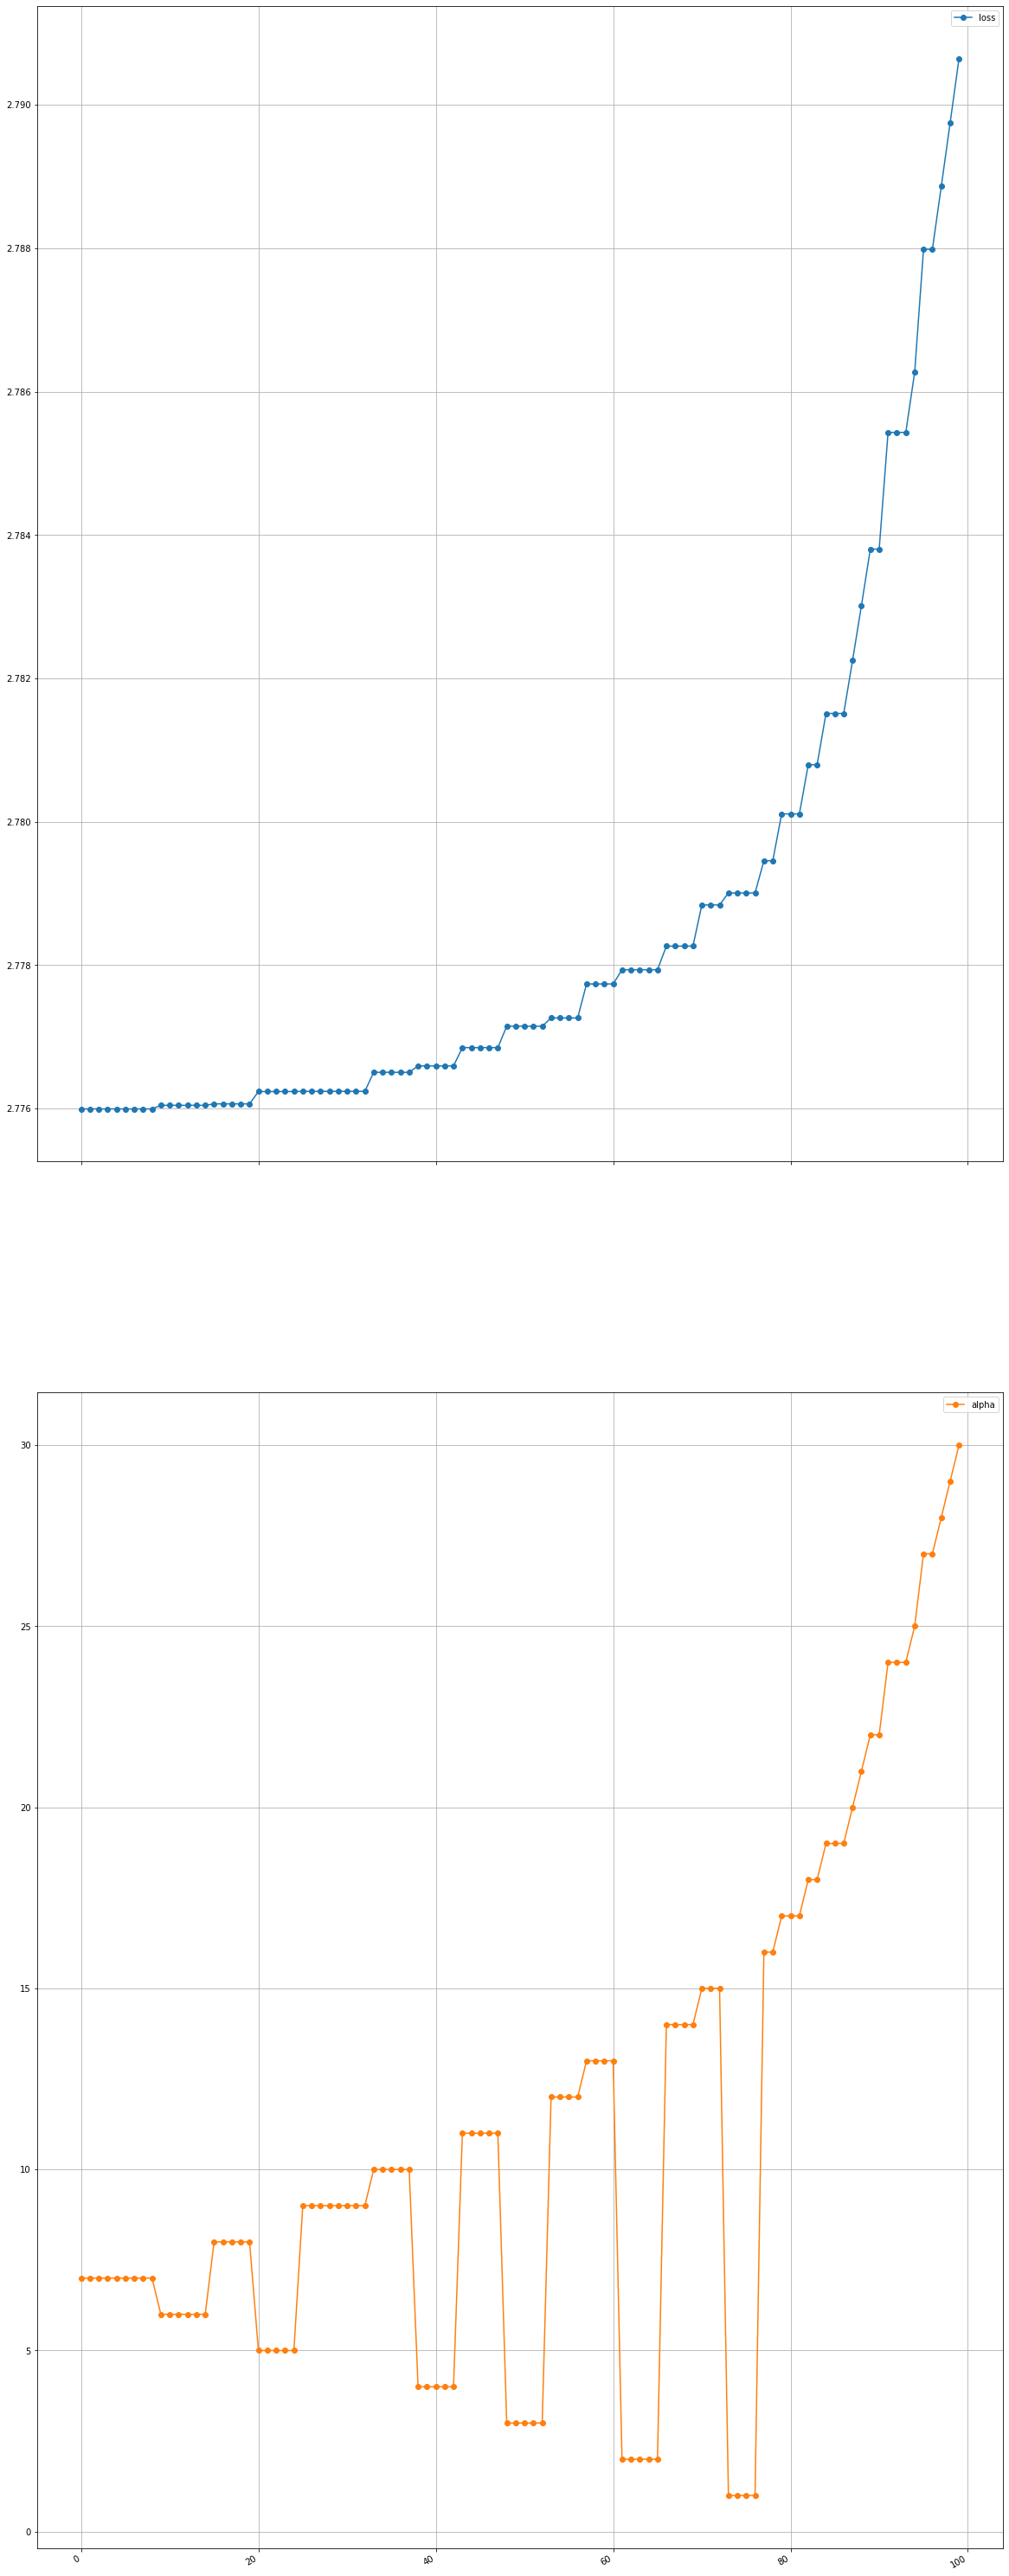

In [44]:
params_rid ={
    'model_type': 'rid',
    'alpha': hp.quniform(label='alpha', low=1, high=30, q=1),
    #'normalize': hp.choice(label='normalize', options=[True, False]),
    #'tol': hp.loguniform(label='tol', low=np.log(1e-8), high=np.log(1.0)),
}

max_evals = 100
trials_rid = Trials()
f_rid = partial(objective, train_x_2, train_y)

best_rid = fmin(
    fn=f_rid, 
    space=params_rid, 
    algo=tpe.suggest, 
    trials=trials_rid,
    max_evals=max_evals
)

print('best_params:')
pprint.pprint(best_rid)
show_trials(trials_rid)

In [50]:
model_2 = Model_Ridge(params=sorted(trials_rid.results, key=lambda x:x['loss'])[0]['params'])
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
score_2 = RMSE(train_y, pred_train_2)
print(f'model_2(rid) score: {score_2:.4f}')

model_2(rid) score: 2.8458


# Create Submission

In [51]:
submission = pd.DataFrame({'id':sample_sub.id})
submission = pd.concat(
    [submission, pd.Series(pred_test_2, name='pred')],
    axis=1
)
display(submission)

,id,pred
0,1,36.232026
1,2,28.528760
2,5,28.030437
3,6,31.404450
4,8,24.947644
...,...,...
495,992,27.861768
496,993,28.851000
497,996,18.355591
498,998,27.958076


## Save files

In [63]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_test.to_pickle('../features/feature_train_test_' + dt + '.pickle')

submission.to_csv('../data/output/sub_' + dt + '.csv', header=False, index=False)

pickle.dump(model_1a.model, open('../models/model_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_1b.model, open('../models/model_' + dt + '_stack_1b_svr.pickle', 'wb'))
pickle.dump(model_1c.model, open('../models/model_' + dt + '_stack_1c_rf.pickle', 'wb'))
pickle.dump(model_2.model, open('../models/model_' + dt + '_stack_2_rid.pickle', 'wb'))

pickle.dump(model_1a.params, open('../logs/params_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_1b.params, open('../logs/params_' + dt + '_stack_1b_svr.pickle', 'wb'))
pickle.dump(model_1c.params, open('../logs/params_' + dt + '_stack_1c_rf.pickle', 'wb'))
pickle.dump(model_2.params, open('../logs/params_' + dt + '_stack_2_rid.pickle', 'wb'))

pd.DataFrame(
    [score_1a, score_1b, score_1c, score_2],
    columns=['score'],
    index=['Layer_1a(lgb)', 'Layer_1b(svr)', 'Layer_1c(rf)', 'Layer_2(rid)']
).to_csv('../logs/train_score_' + dt + '.csv')